# Imports

In [1]:
# Add the directory where starships' directory is located
from sys import path
path.append('/home/mathisb/Github/')

# Add the directory containing the input data (opacity, abundance and stellar specs files)
import os
os.environ['pRT_input_data_path'] = '/home/mathisb/projects/def-ncowan/input_data'


In [2]:
from pathlib import Path

import matplotlib.pyplot as plt
import starships.homemade as hm
from starships import spectrum as spectrum
from starships.mask_tools import interp1d_masked

interp1d_masked.iprint=False
import warnings

import astropy.constants as const
import astropy.units as u
import numpy as np
import starships.planet_obs as pl_obs
import starships.plotting_fcts as pf
from starships.planet_obs import Observations

warnings.simplefilter("ignore", UserWarning)
warnings.simplefilter("ignore", RuntimeWarning)

# Get planet info and determine directories to use

In [15]:
#--------------------------------------------------------------------------------------------
# Planet, night, reduction and instrument
pl_name = 'TRAPPIST-1 b'
visit_name = '2020-08-04'
reduction = 'v001'
instrument = "SPIRou"

#--------------------------------------------------------------------------------------------

# Directory where to save reductions
# > use scratch if available, use home if not
try:
    out_dir = Path(os.environ['SCRATCH'])
except KeyError:
    out_dir = Path.home()

# Output reductions in dedicated directory
pl_name_fname = ''.join(pl_name.split())
out_dir /= Path(f'HRS_reductions/{instrument}/{pl_name_fname}/{visit_name}/{reduction}')
# Make sure the  directory exists
out_dir.mkdir(parents=True, exist_ok=True)


In [16]:
# Relevant directories

# Where to find the observations (data)?
obs_dir = f"/home/mathisb/Github/HRS_data/{instrument}/TRAPPIST-1/{visit_name}/"  # for TRAPPIST-1 SPIRou data

# Where to save figures?
path_fig = Path(f'HRS_reductions/{instrument}/{pl_name_fname}/{visit_name}/Figures')

In [17]:
# All the observations must be listed in files.
# We need the e2ds, the telluric corrected and the reconstructed spectra.

list_filenames = {'list_e2ds': 'list_e2ds.txt',
                  'list_tcorr': 'list_tcorr.txt'}


In [18]:
# SPECIFY PARAMETERS OF THE PLANET
# If not specified, the default parameters from exofile are taken.

# Most parameters from trappist.one website
ap     = 0.01150*u.au       # semi-major axis of planet
R_star = 0.121*u.R_sun      # radius of star
R_pl   = 1.127*u.R_earth    # radius of planet
M_star = 0.089*const.M_sun  # mass of star
e      = 0                  # eccentricity
w      = 4.712389*u.rad     # argument of periapsis (equal to 270 degrees)

# Mid-transit time (BJD) of this visit
mid_tr = 2459066.07480784*u.d  # calculated from Agol et al. 2021



#--------------------------------------------------------------------------------------------


obs = Observations(name=pl_name, 
                   pl_kwargs = {'M_star': M_star, 
                                'R_star': R_star,
                                'ap': ap,
                                'R_pl': R_pl,
                                'mid_tr': mid_tr,
                                'excent': e,
                                'w': w})

# Get the data
obs.fetch_data(obs_dir, **list_filenames, CADC=True)
p = obs.planet

Getting TRAPPIST-1 b from ExoFile


INFO:starships.planet_obs:Fetching data


Changing M_star from [1.5907279e+29] kg to 1.769684784921265e+29 kg
It became [1.76968478e+29] kg
Changing R_star from [0.] m to 0.121 solRad
It became [84179700.] m
Changing ap from [1.72546184e+09] m to 0.0115 AU
It became [1.72037551e+09] m
Changing R_pl from [6934724.] m to 1.127 earthRad
It became [7188118.7] m
Changing mid_tr from [2457322.514193] d to 2459066.07480784 d
It became [2459066.07480784] d
Changing excent from pl_orbeccen
-----------
    0.00622 to 0
It became 0
Changing w from [10.5917051] rad to 4.712389 rad
It became [4.712389] rad


INFO:starships.planet_obs:Fetching the uncorrected spectra


# Look at the reductions

[2459066.07480784] d
Transmission


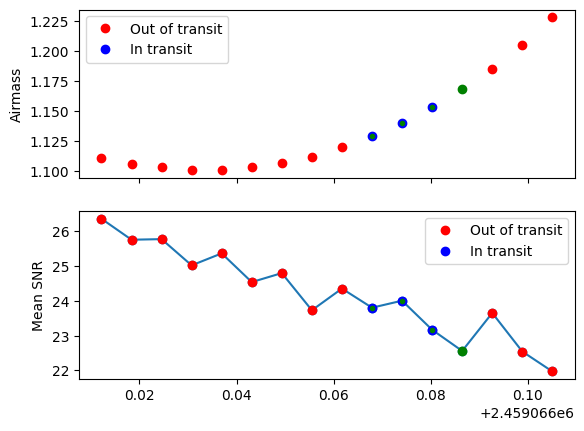

In [21]:
# Name of reduction sequence files
seq_file_list = [#"sequence_1-pc_mask_wings97_data_trs_2020-08-04.npz",
                 "sequence_2-pc_mask_wings97_data_trs_2020-08-04.npz",
                 # "sequence_3-pc_mask_wings97_data_trs_2020-08-04.npz",
                 # "sequence_4-pc_mask_wings97_data_trs_2020-08-04.npz",
                 # "sequence_5-pc_mask_wings97_data_trs_2020-08-04.npz",
                 # "sequence_6-pc_mask_wings97_data_trs_2020-08-04.npz",
                 # "sequence_7-pc_mask_wings97_data_trs_2020-08-04.npz",
                ]

#----------------------------#

# Plot airmass and mean SNR
seq_obj_list = []

for seq_file in seq_file_list:
    sequence_obj = pl_obs.load_single_sequences(seq_file, name=pl_name, planet=p, path=out_dir, load_all=True)
    seq_obj_list.append(sequence_obj)

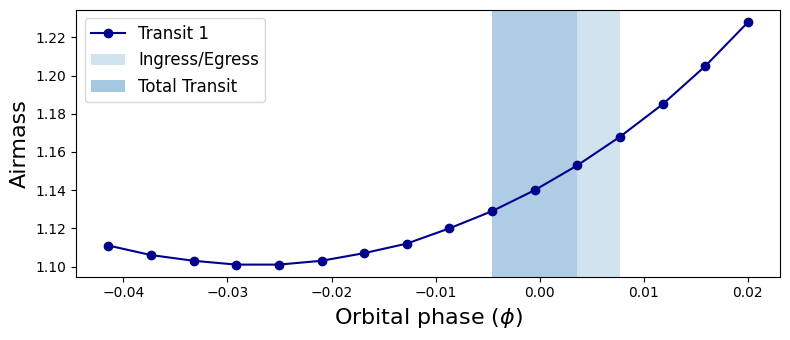

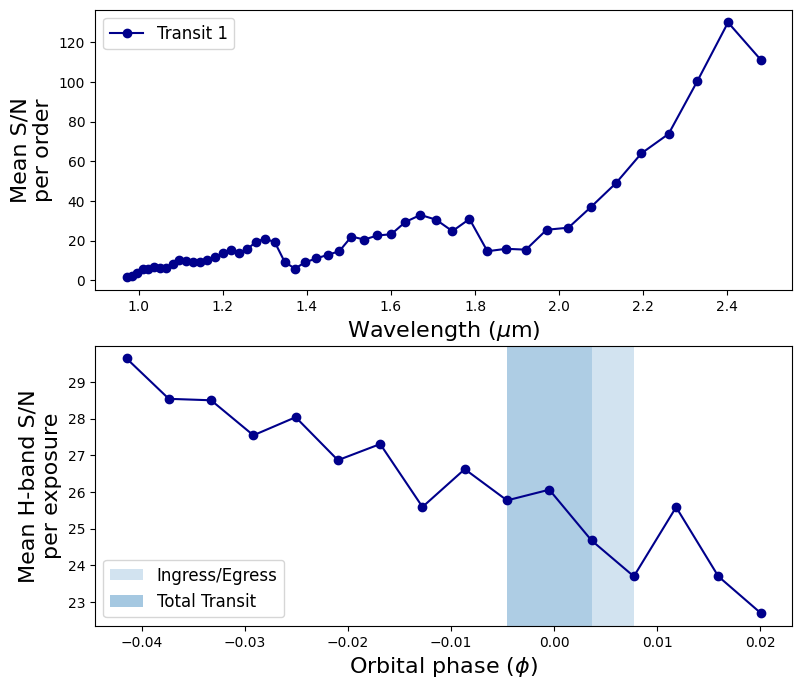

In [22]:
# Plot airmass and mean SNR per order/exposure

for seq_obj in seq_obj_list:
    pf.plot_airmass([seq_obj])

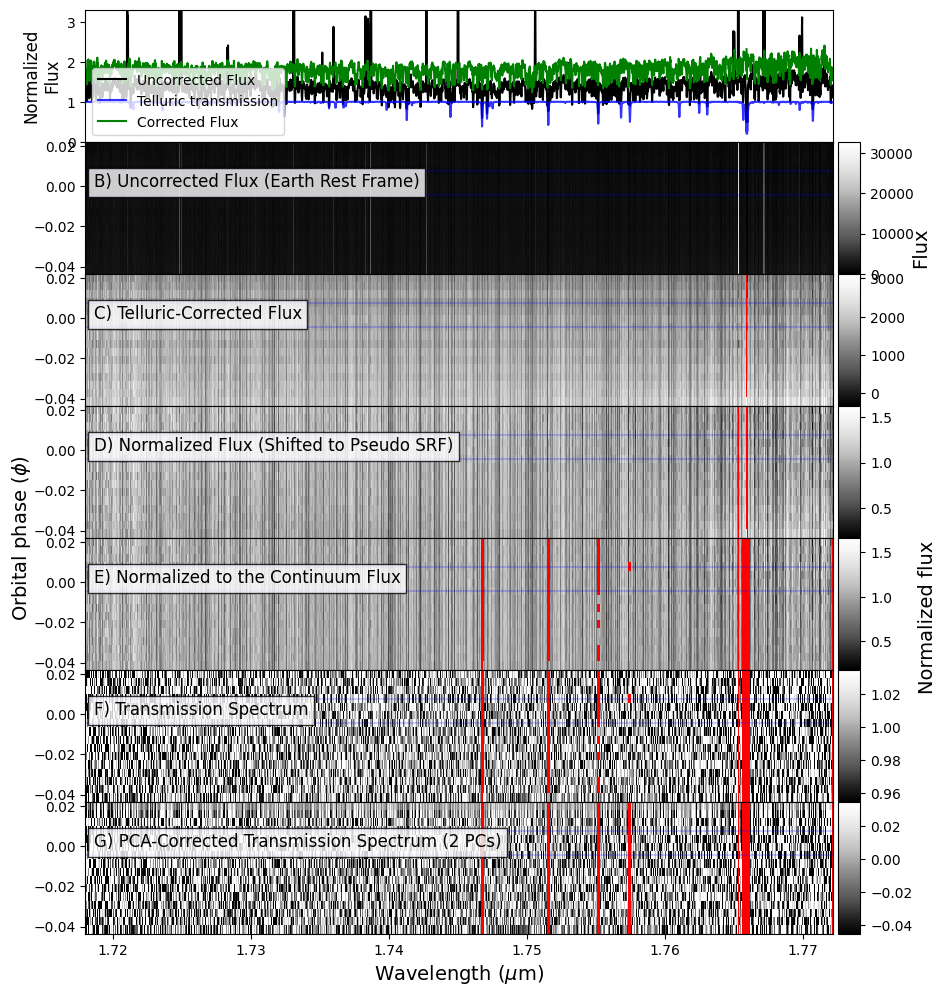

In [23]:
# Order to plot
order_plot = 36
#--------------#

# Plot the reductions steps

for seq_obj in seq_obj_list:
    plot_steps = pf.plot_steps(seq_obj, order_plot - 1)
plt.show()

IndexError: index -15 is out of bounds for axis 0 with size 14

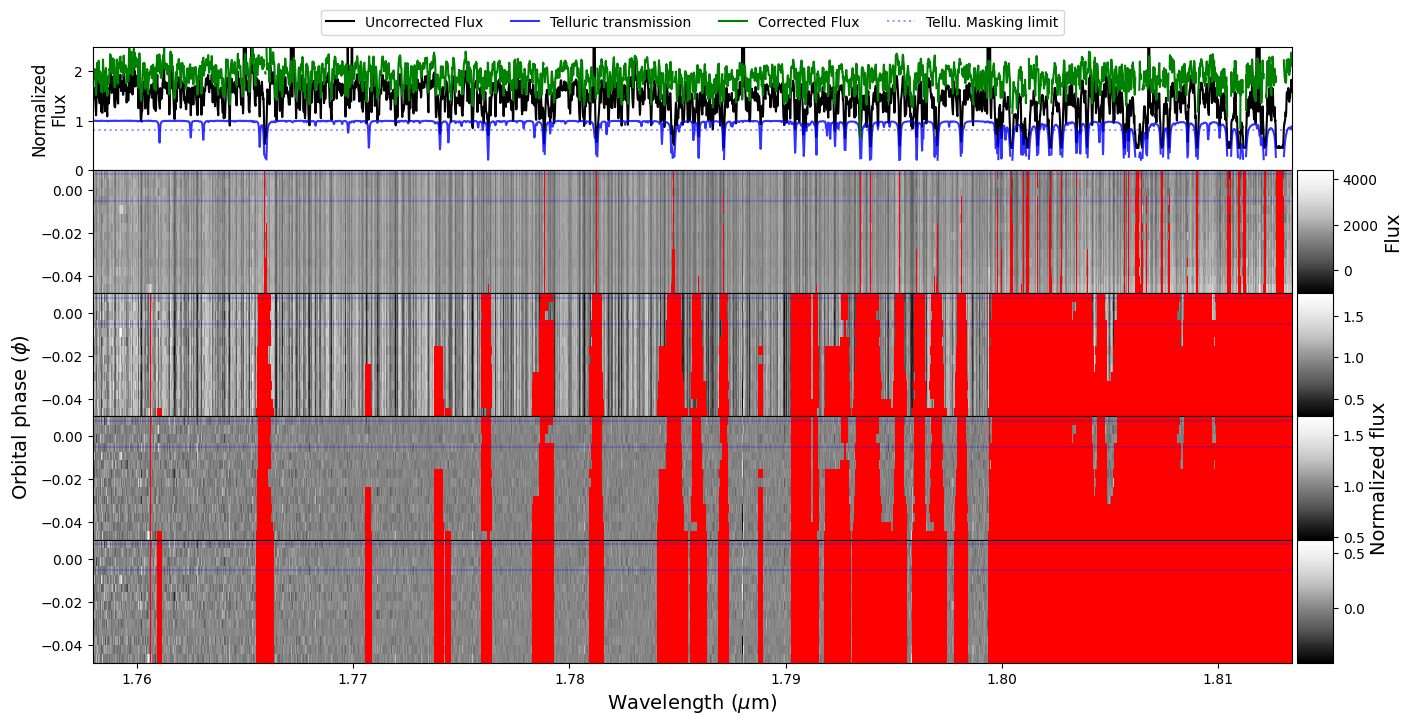

In [10]:
# Plot fewer steps

for seq_obj in seq_obj_list:
    plot_few_steps = pf.plot_five_steps(seq_obj, order_plot)

The fraction of masked data points is 0.4144156990095451


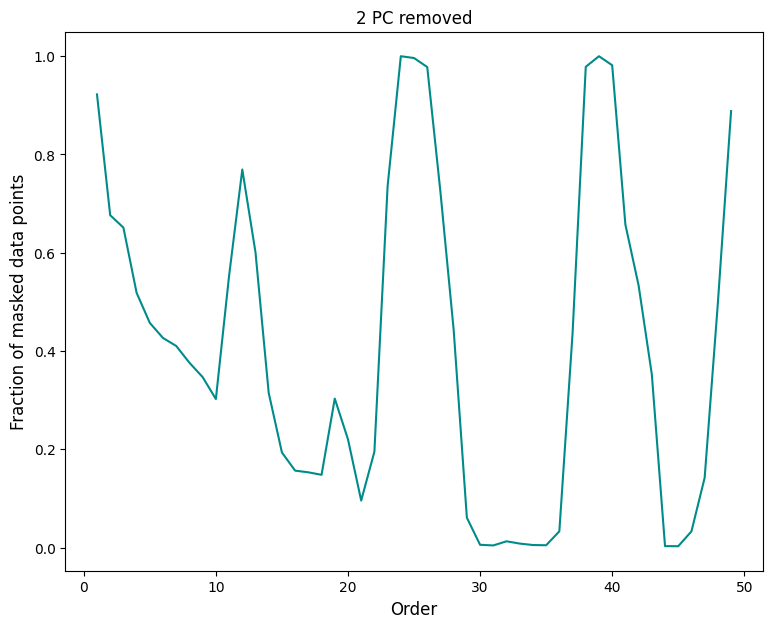

In [24]:
# Plot ratio of masked data points at each order

# Calculate overall ratio of masked data points
masked_ratio_total = [seq_obj.final.mask.sum() / seq_obj.final.size for seq_obj in seq_obj_list]
print("The fraction of masked data points is", masked_ratio_total[0])

# Plot ratio of masked data points per order, for each nPC
masked_ratio = np.array([seq_obj.final.mask.sum(axis=0).sum(axis=-1) / seq_obj.final.shape[0] / seq_obj.final.shape[-1]
                         for seq_obj in seq_obj_list])

n_pc_list = np.array([seq_obj.params[5] for seq_obj in seq_obj_list])  # list of nPC for each observation

fig, axs = plt.subplots(len(n_pc_list), sharex=True, squeeze=False, figsize=(9,7))

for n in range(len(n_pc_list)):
    order_list = np.arange(1, len(masked_ratio[n]) + 1)
    axs[n,0].plot(order_list, masked_ratio[n], color="darkcyan")
    axs[n,0].set_title("{} PC removed".format(n_pc_list[n]))

axs[len(n_pc_list) // 2, 0].set_ylabel("Fraction of masked data points", fontsize=12)
plt.xlabel("Order", fontsize=12)
plt.show()

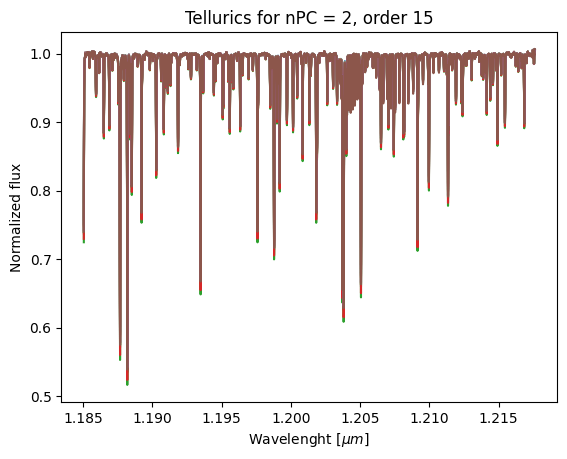

In [25]:
#-----------------------------------------------#
# Plot tellurics for a specific nPC and order
tellu_plot_nPC = 2
tellu_plot_order = 15
#-----------------------------------------------#

nPC_idx = np.where(n_pc_list == tellu_plot_nPC)[0][0]
plt.plot(seq_obj_list[nPC_idx].wave[:, tellu_plot_order, :].T, seq_obj_list[nPC_idx].tellu[:, tellu_plot_order, :].T)

plt.title("Tellurics for nPC = {}, order {}".format(tellu_plot_nPC, tellu_plot_order))
plt.xlabel("Wavelenght [$\mu{}m$]")
plt.ylabel("Normalized flux")
plt.show()

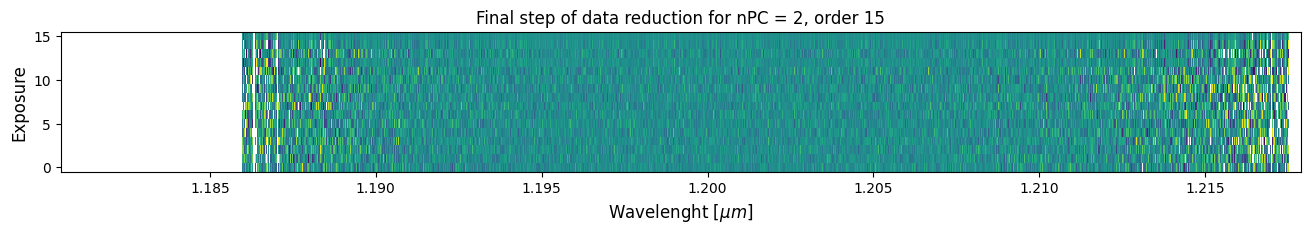

In [26]:
#---------------------------------------------------------------#
# Plot final step of data reduction for a specific nPC and order
final_plot_nPC = 2
final_plot_order = 15
#---------------------------------------------------------------#

nPC_idx = np.where(n_pc_list == final_plot_nPC)[0][0]
pf.plot_order(seq_obj_list[nPC_idx], final_plot_order, xlabel="Wavelenght [$\mu{}m$]", ylabel="Exposure",
              title="Final step of data reduction for nPC = {}, order {}".format(final_plot_nPC, final_plot_order))